In [1]:
import sys
sys.path.append('/home/npopkov/dll24')

import matplotlib.pyplot as plt
import torch
torch.backends.cudnn.benchmark = True

import numpy as np
import lightning as lt
torch.set_float32_matmul_precision('medium')
import soundfile as sf

from torch.utils.data import DataLoader,Dataset

import h5py
from tqdm.auto import tqdm 

class SnippetDatasetHDF(Dataset):
    def __init__(self, hdf, scaling='standard'):
        self.num_rows = 0
        self.size = 2**16
        self.data = []
        self.scaling = scaling
        self.createData(hdf)
        self.lens = [len(sample) for sample in self.data]
        
        if self.scaling == 'standard':
            self.mean = self.data.mean()
            self.std =  self.data.std()
            self.data = (self.data - self.mean) / self.std
        
        if self.scaling == 'minmax':
            self.min = self.data.min()
            self.max = self.data.max()
            self.data = (self.data - self.min) / (self.max - self.min)
    
    def __len__(self):
        return self.num_rows
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def createData(self, hdf):
        data = []
        keys = list(hdf.keys())
        self.num_rows = len(keys)
        for key in tqdm(keys):
            sample = hdf[key]['audio'][:]
            if len(sample) > self.size:
               self.num_rows -= 1
               continue
            
            if len(sample) < self.size:
                sample = np.pad(sample, (0, self.size - len(sample)), 'constant')



            data.append(sample)
         
        self.data = torch.tensor(np.array(data)).float()
    
    def retransform(self, data):
        if self.scaling == 'standard':
            return data * self.std + self.mean
        if self.scaling == 'minmax':
            return data * (self.max - self.min) + self.min
         

hdf = h5py.File('../test.hdf5', 'r')
dataset = SnippetDatasetHDF(hdf)
hdf.close()



  0%|          | 0/6675 [00:00<?, ?it/s]

In [2]:
from audio_diffusion_pytorch import DiffusionAE, UNetV0, VDiffusion, VSampler
from audio_encoders_pytorch import MelE1d, TanhBottleneck 

autoencoder = DiffusionAE(
    encoder=MelE1d( # The encoder used, in this case a mel-spectrogram encoder
        in_channels=1,
        channels=512,
        multipliers=[1, 1],
        factors=[2],
        num_blocks=[12],
        out_channels=64,
        mel_channels=160,
        mel_sample_rate=32000,
        mel_normalize_log=True,
        bottleneck=TanhBottleneck(),
    ),
    inject_depth=6,
    net_t=UNetV0, # The model type used for diffusion upsampling
    in_channels=1, # U-Net: number of input/output (audio) channels
    channels=[8, 32, 64, 128, 256, 512, 512, 1024, 1024], # U-Net: channels at each layer
    factors=[1, 4, 4, 4, 2, 2, 2, 2, 2], # U-Net: downsampling and upsampling factors at each layer
    items=[1, 2, 2, 2, 2, 2, 2, 4, 4], # U-Net: number of repeating items at each layer
    diffusion_t=VDiffusion, # The diffusion method used
    sampler_t=VSampler, # The diffusion sampler used
)

class Lightningwrapper(lt.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        loss = self.model(batch.unsqueeze(1))
        self.log('train_loss', loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=3e-4)

model = Lightningwrapper(autoencoder)
trainer = lt.Trainer(max_epochs = 100)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=30,drop_last=True)
trainer.fit(model,dataloader)

/home/npopkov/.local/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (160) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-08-22 13:37:49.270410: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-22 13:37:49.277533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 13:37:49.284570: E external/local_xla/xla/stream_executor/c

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [4]:
sample = dataset[:16]
latent = autoencoder.encode(sample.unsqueeze(1))
print("latent shape: ",latent.shape)
reconstructed = autoencoder.decode(latent,num_steps=200)


latent shape:  torch.Size([16, 64, 128])


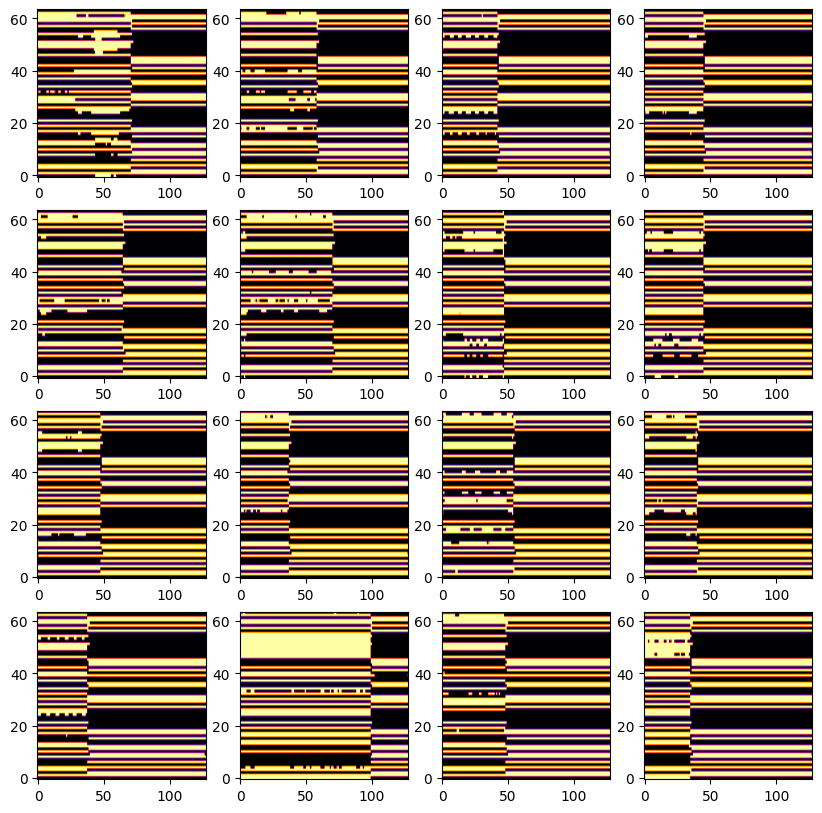

In [5]:
fig , ax = plt.subplots(4,4,figsize=(10,10))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(latent[i*4+j].detach().cpu().numpy(),aspect='auto',origin='lower',cmap='inferno')

In [13]:
from IPython.display import Audio
Audio(reconstructed[9].squeeze().detach().numpy(), rate=32000)


In [10]:
Audio(sample[2].squeeze().detach().numpy(), rate=32000)

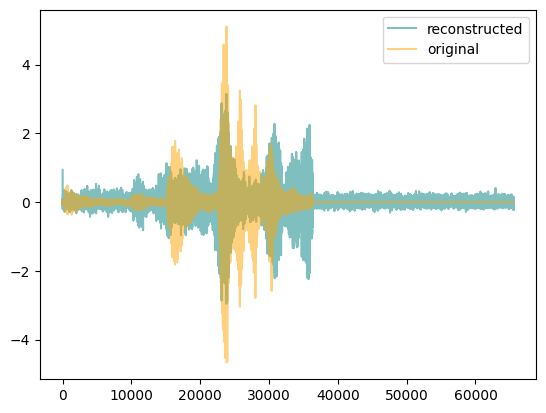

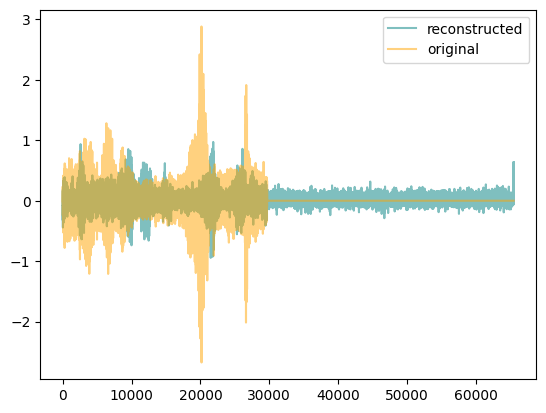

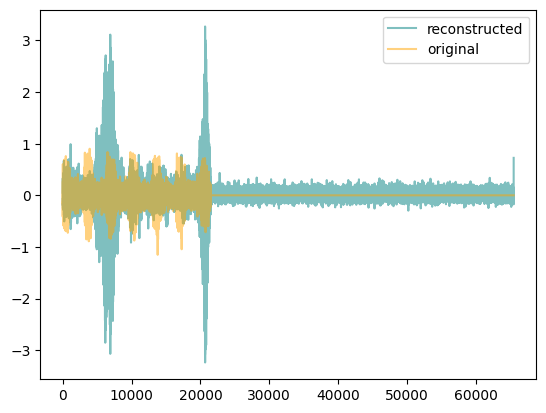

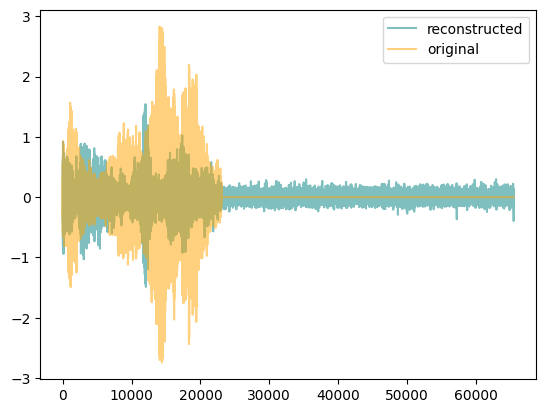

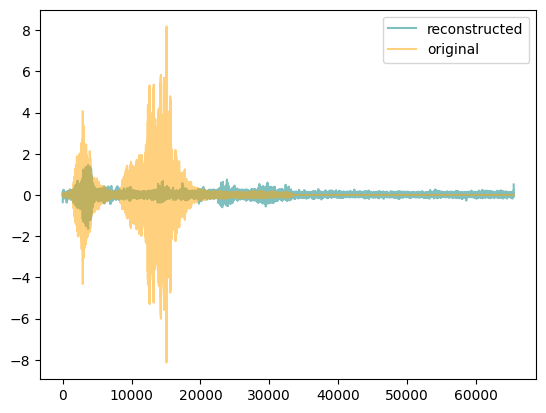

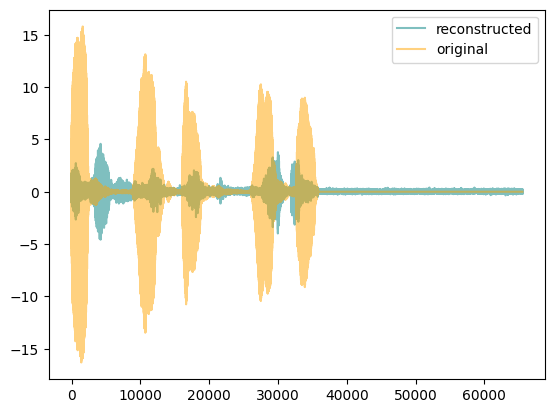

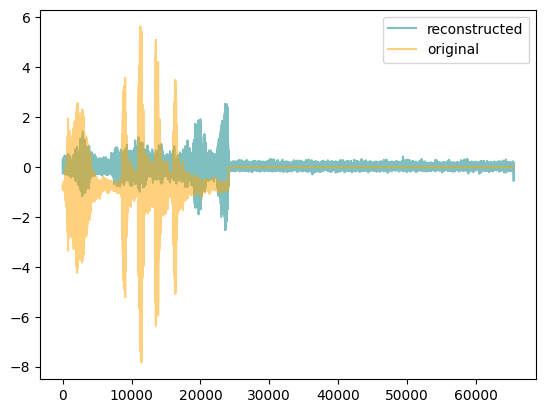

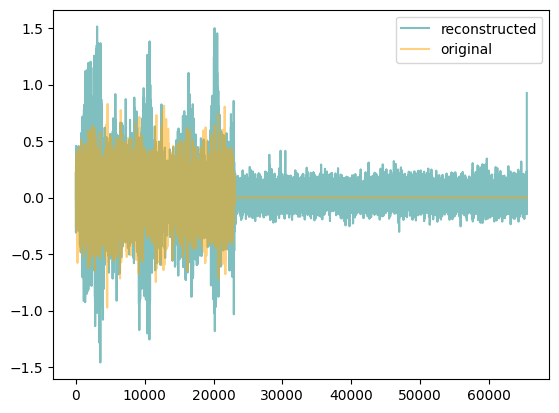

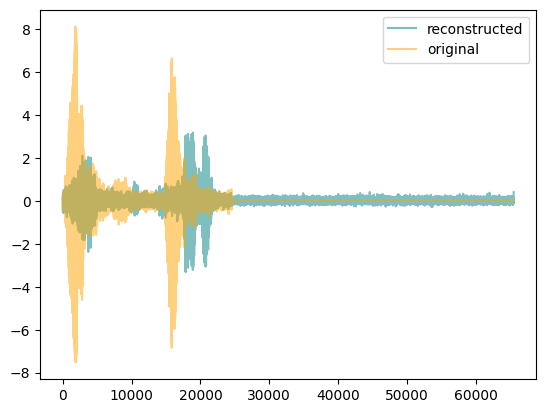

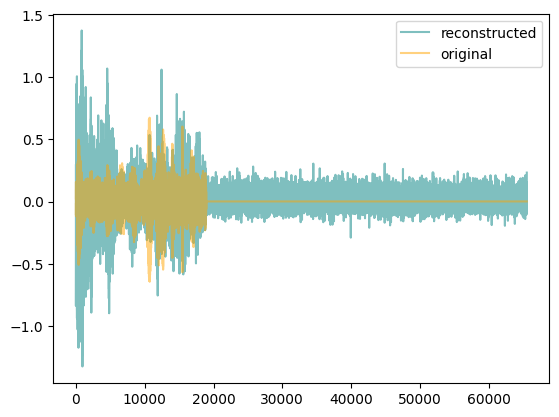

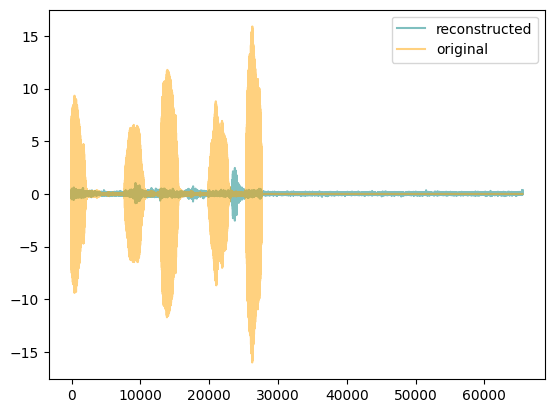

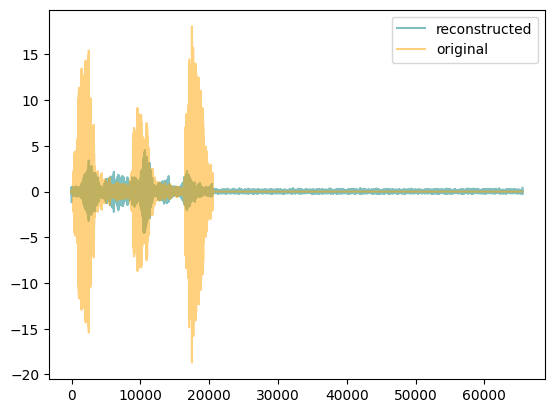

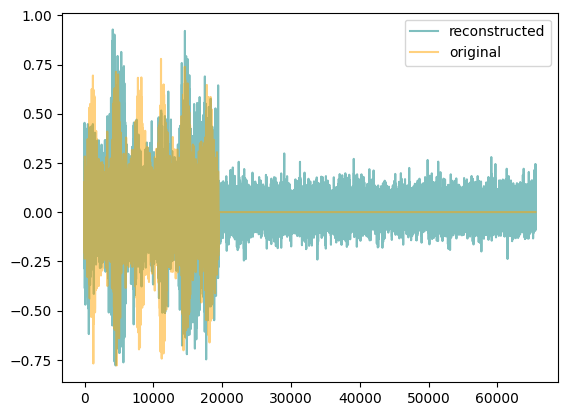

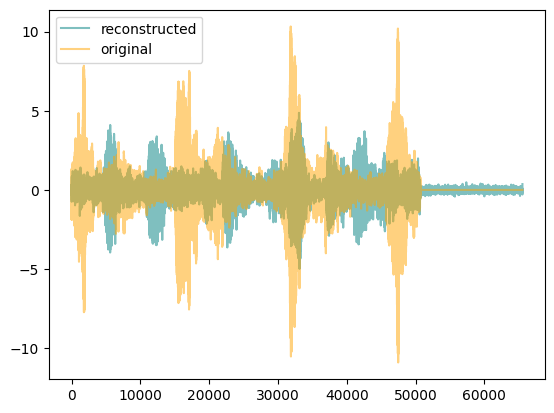

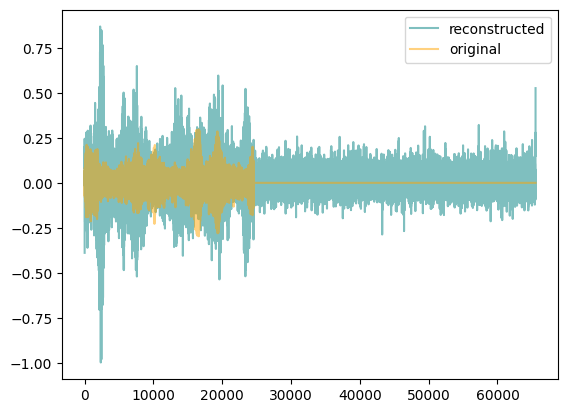

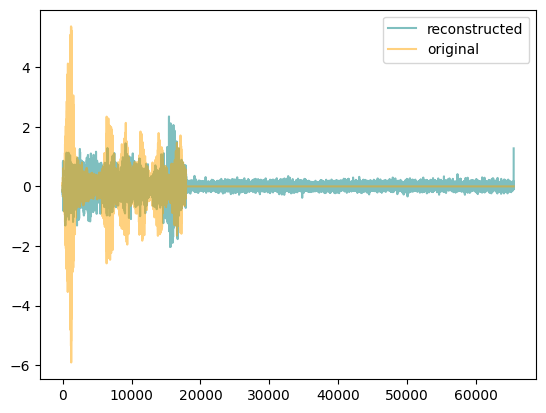

In [11]:
for i in range(16):
    plt.plot(reconstructed[i].squeeze().detach().numpy(), label='reconstructed',alpha=0.5, color='teal')
    plt.plot(sample[i].squeeze().detach().numpy(), label='original',alpha=0.5, color='orange')
    plt.legend()
    plt.show()
